# Quantifying Greenwashing
Data has already been cleaned and processed in previous notebook.

In [176]:
# Data Management/Investigation
import pandas as pd
from pandas.api.types import CategoricalDtype # Ordering categories
import numpy as np
import missingno as miss

# Plotting libraries
from plotnine import *
import matplotlib.pyplot as plt

# For pre-processing data 
from sklearn import preprocessing as pp 
from sklearn.compose import ColumnTransformer 

# For splits and CV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold # Cross validation 
from sklearn.model_selection import cross_validate # Cross validation 
from sklearn.model_selection import GridSearchCV # Cross validation + param. tuning.

# Machine learning methods 
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.tree import DecisionTreeRegressor as DT_reg
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import tree # For plotting the decision tree rules

# For evaluating our model's performance
import sklearn.metrics as m

# Pipeline to combine modeling elements
from sklearn.pipeline import Pipeline

# Misc
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

## import greenwashing words as list
greenwords = open("greenwords.txt", "r")
greenwords = greenwords.readlines()
greenwords = [s.rstrip() for s in greenwords]

# Data

In [58]:
## import data
dat = pd.read_csv("greenwashing_data.csv")

In [59]:
dat.dtypes

username                             object
environment_rating                  float64
('is_video', 'mean')                float64
('is_sponsored', 'mean')            float64
('caption_num_words', 'mean')       float64
('caption_unique_words', 'mean')    float64
('mention_counts', 'mean')          float64
('hashtag_counts', 'mean')          float64
('emoji_counts', 'mean')            float64
LN_total_green                      float64
LN_EMPLOYEES                        float64
LN_REVENUES                         float64
LN_PROFIT                           float64
LN('likes', 'sum')                  float64
LN('likes', 'mean')                 float64
LN('comments', 'sum')               float64
LN('comments', 'mean')              float64
LN_total_green_mentions             float64
LN_total_green_hashtags             float64
LN_total_green_caption              float64
LN_total_green_caption.1            float64
('likely_automated', 'mean')        float64
dtype: object

In [60]:
## change dependent variable to bins
dat['rating_bins'] = pd.qcut(dat['environment_rating'], 2, labels=False)

#y_map = {0: 'A', 1: 'B', 2: 'C', 3 : 'D'}

## is_video
#dat['rating_bins'] = dat['rating_bins'].map(y_map)

# Split Data
##### Again, data was alreaady pre-processed!

In [83]:
y = dat[['rating_bins']]
X = dat.drop(columns=['username','rating_bins', 'environment_rating', 'LN_PROFIT'])

train_X, test_X, train_y, test_y = train_test_split(X,y,test_size = .25,random_state=123)

# Train Model

##### Cross Validation

In [78]:
# Set the folds index to ensure comparable samples
fold_generator = KFold(n_splits=10, shuffle=True,random_state=1234)

##### Initialize Pipeline

In [79]:
pipe = Pipeline(steps=[('pre_process', pp.MinMaxScaler()),('model',None)])

##### Tuning Parameters

In [80]:
search_space = [
    
    # NaiveBayes
    {'model': [NB()]},
    
    # KNN with K tuning param
    {'model' : [KNN()],
     'model__n_neighbors':[5,10,25,50]},
    
    # Decision Tree with the Max Depth Param
    {'model': [DT()],
     'model__max_depth':[2,3,4]},
    
    # Random forest with the N Estimators tuning param
    {'model' : [RF()],
    'model__max_depth':[2,3,4],
    'model__n_estimators':[500,1000,1500]}
    
]

In [81]:
search = GridSearchCV(pipe, search_space, 
                      cv = fold_generator,
                      scoring='roc_auc',
                      n_jobs=4)

In [84]:
search.fit(train_X,train_y)

GridSearchCV(cv=KFold(n_splits=10, random_state=1234, shuffle=True),
             estimator=Pipeline(steps=[('pre_process', MinMaxScaler()),
                                       ('model', None)]),
             n_jobs=4,
             param_grid=[{'model': [GaussianNB()]},
                         {'model': [KNeighborsClassifier()],
                          'model__n_neighbors': [5, 10, 25, 50]},
                         {'model': [DecisionTreeClassifier()],
                          'model__max_depth': [2, 3, 4]},
                         {'model': [RandomForestClassifier(max_depth=2,
                                                           n_estimators=1500)],
                          'model__max_depth': [2, 3, 4],
                          'model__n_estimators': [500, 1000, 1500]}],
             scoring='roc_auc')

In [85]:
search.best_score_

0.760047619047619

In [86]:
search.best_params_

{'model': RandomForestClassifier(max_depth=2, n_estimators=1500),
 'model__max_depth': 2,
 'model__n_estimators': 1500}

In [87]:
rf_mod = search.best_estimator_

In [88]:
m.roc_auc_score(train_y,rf_mod.predict_proba(train_X)[:,1])

0.9478021978021978

In [89]:
m.accuracy_score(train_y,rf_mod.predict(train_X))

0.8796296296296297

## Model Interpretation

In [53]:
from sklearn.inspection import partial_dependence
from sklearn.inspection import plot_partial_dependence

In [54]:
from sklearn.inspection import permutation_importance

In [90]:
vi = permutation_importance(rf_mod,train_X,train_y,n_repeats=5)

In [91]:
# Organize as a data frame 
vi_dat = pd.DataFrame(dict(variable=train_X.columns,
                           vi = vi['importances_mean'],
                           std = vi['importances_std']))

# Generate intervals
vi_dat['low'] = vi_dat['vi'] - 2*vi_dat['std']
vi_dat['high'] = vi_dat['vi'] + 2*vi_dat['std']

# But in order from most to least important
vi_dat = vi_dat.sort_values(by="vi",ascending=False).reset_index(drop=True)


vi_dat

,variable,vi,std,low,high
0,"('is_video', 'mean')",9.629630e-02,0.019945,0.056406,0.136186
1,LN_REVENUES,4.074074e-02,0.027839,-0.014938,0.096420
2,"('hashtag_counts', 'mean')",2.962963e-02,0.003704,0.022222,0.037037
3,"LN('comments', 'mean')",1.296296e-02,0.004536,0.003891,0.022035
4,LN_EMPLOYEES,1.296296e-02,0.022376,-0.031789,0.057715
5,"('emoji_counts', 'mean')",1.111111e-02,0.003704,0.003704,0.018519
6,LN_total_green,1.111111e-02,0.003704,0.003704,0.018519
7,"('mention_counts', 'mean')",7.407407e-03,0.017954,-0.028501,0.043316
8,"LN('comments', 'sum')",7.407407e-03,0.006929,-0.006451,0.021265
9,"LN('likes', 'sum')",5.555556e-03,0.004536,-0.003517,0.014628


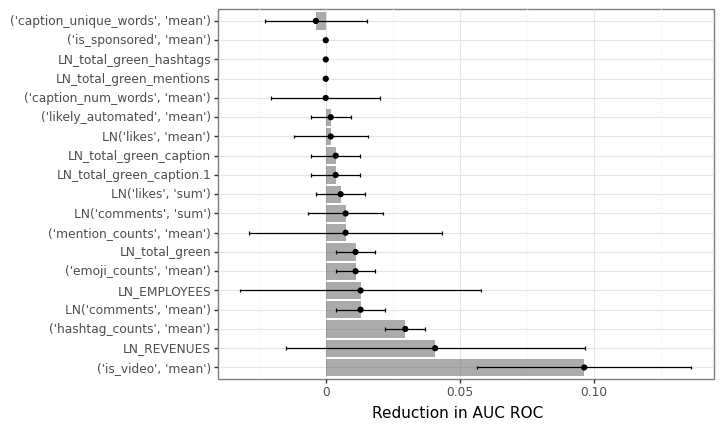

<ggplot: (138064512004)>

In [92]:
# Plot
(
    ggplot(vi_dat,
          aes(x="variable",y="vi")) +
    geom_col(alpha=.5) +
    geom_point() +
    geom_errorbar(aes(ymin="low",ymax="high"),width=.2) +
    theme_bw() +
    scale_x_discrete(limits=vi_dat.variable.tolist()) +
    coord_flip() +
    labs(y="Reduction in AUC ROC",x="")
)

## Partial Dependency

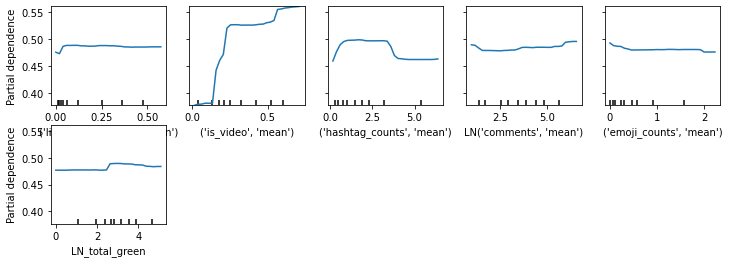

In [93]:
# Target specific features
features = ["('likely_automated', 'mean')", "('is_video', 'mean')","('hashtag_counts', 'mean')","LN('comments', 'mean')","('emoji_counts', 'mean')","LN_total_green"]

# Calculate the partial dependency
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    rf_mod, train_X, features,n_cols=5,
    n_jobs=4, grid_resolution=30,ax=ax
)

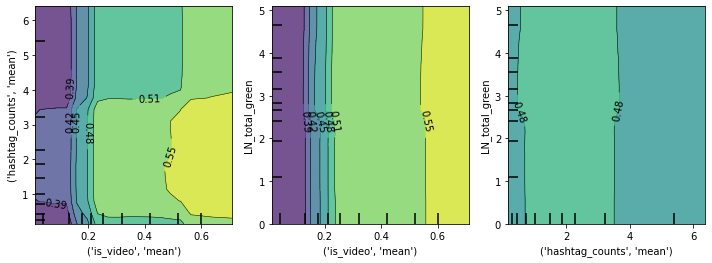

In [94]:
# Feed in the ineraction as a nested list
interacted_features = [["('is_video', 'mean')","('hashtag_counts', 'mean')"],["('is_video', 'mean')","LN_total_green"],["('hashtag_counts', 'mean')","LN_total_green"]] 

# Then business as usual when plotting
fig, ax = plt.subplots(figsize=(12, 4))
display = plot_partial_dependence(
    rf_mod, train_X, interacted_features,
    n_cols=3,n_jobs=4, grid_resolution=20,ax=ax
)

In [128]:
from pdpbox import pdp

In [129]:
pdp_dist = pdp.pdp_isolate(model = rf_mod, 
                           dataset = train_X,
                           model_features = train_X.columns.tolist(),
                           feature="('is_video', 'mean')")

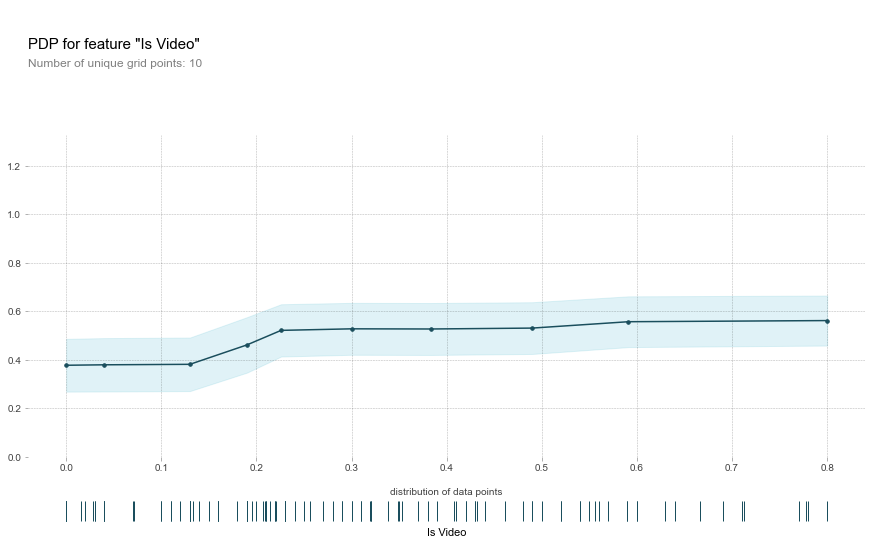

In [131]:
fig,ax = pdp.pdp_plot(pdp_dist,'Is Video',plot_pts_dist=True,center=False,)

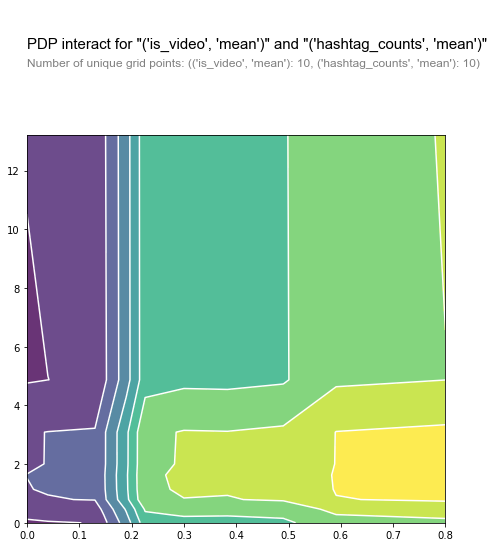

In [132]:
inter1  =  pdp.pdp_interact(model = rf_mod, 
                            dataset = train_X,
                            model_features = train_X.columns,
                            features=["('is_video', 'mean')","('hashtag_counts', 'mean')"])

# Using a try-except clause due to a dependency error. Not ideal, but want to show the api. 
try:
    fig,ax = pdp.pdp_interact_plot(pdp_interact_out=inter1, 
                                   feature_names=["('is_video', 'mean')","('hashtag_counts', 'mean')"],
                                   plot_type="contour")
except:
    print("")

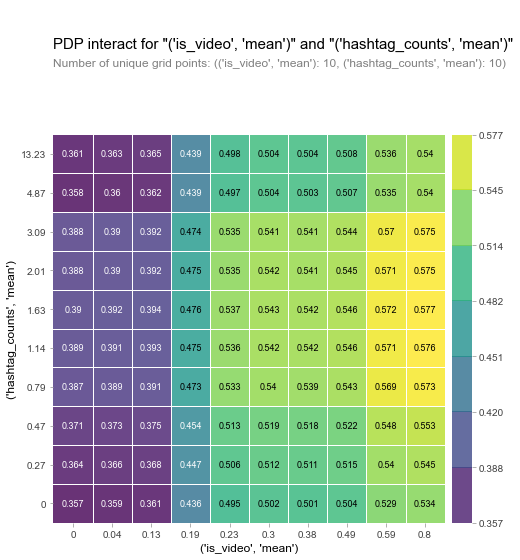

In [133]:
fig,ax = pdp.pdp_interact_plot(pdp_interact_out=inter1, 
                               feature_names=["('is_video', 'mean')","('hashtag_counts', 'mean')"],
                               plot_type="grid")

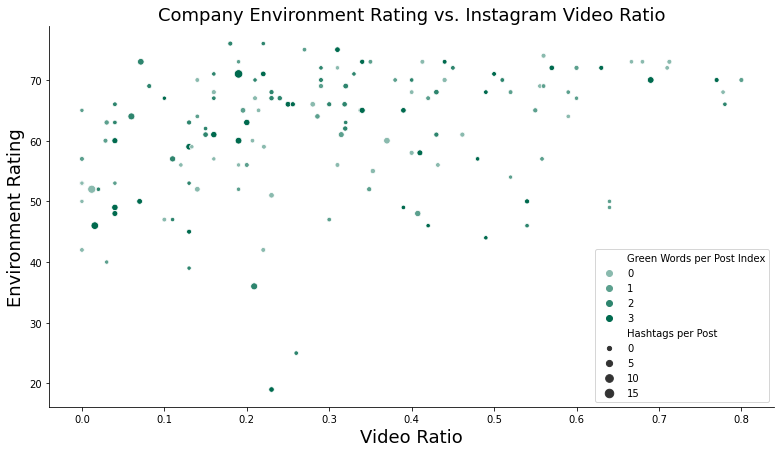

In [179]:
# Create an array with the colors you want to use
colors = ["#8ABAAE","#5CA08E", "#2E856E","#006A4E"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

dat['Green Words per Post Index'] = pd.qcut(dat["LN_total_green"], 4, labels=False)
dat['Hashtags per Post'] = dat["('hashtag_counts', 'mean')"]
fig, ax = plt.subplots(figsize = (13, 7))
#dat['Green Index'] = pd.qcut(dat["LN_total_green"], 4, labels=False)
sns.scatterplot(data=dat, x="('is_video', 'mean')", y="environment_rating", hue = 'Green Words per Post Index', s = 1000, size = "Hashtags per Post",palette = colors)


# Customize the axes and title
ax.set_title("Company Environment Rating vs. Instagram Video Ratio", fontsize = 18)
ax.set_xlabel("Video Ratio", fontsize = 18)
ax.set_ylabel("Environment Rating", fontsize = 18)



# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

## Surrogate Model

In [99]:
pr_y = rf_mod.predict_proba(train_X)[:,rf_mod.classes_ == 1]


In [96]:
surrogate_model = DT_reg(max_depth=3)
surrogate_model.fit(train_X,pr_y)

DecisionTreeRegressor(max_depth=3)

In [97]:
m.r2_score(pr_y,surrogate_model.predict(train_X)).round(2)

0.87

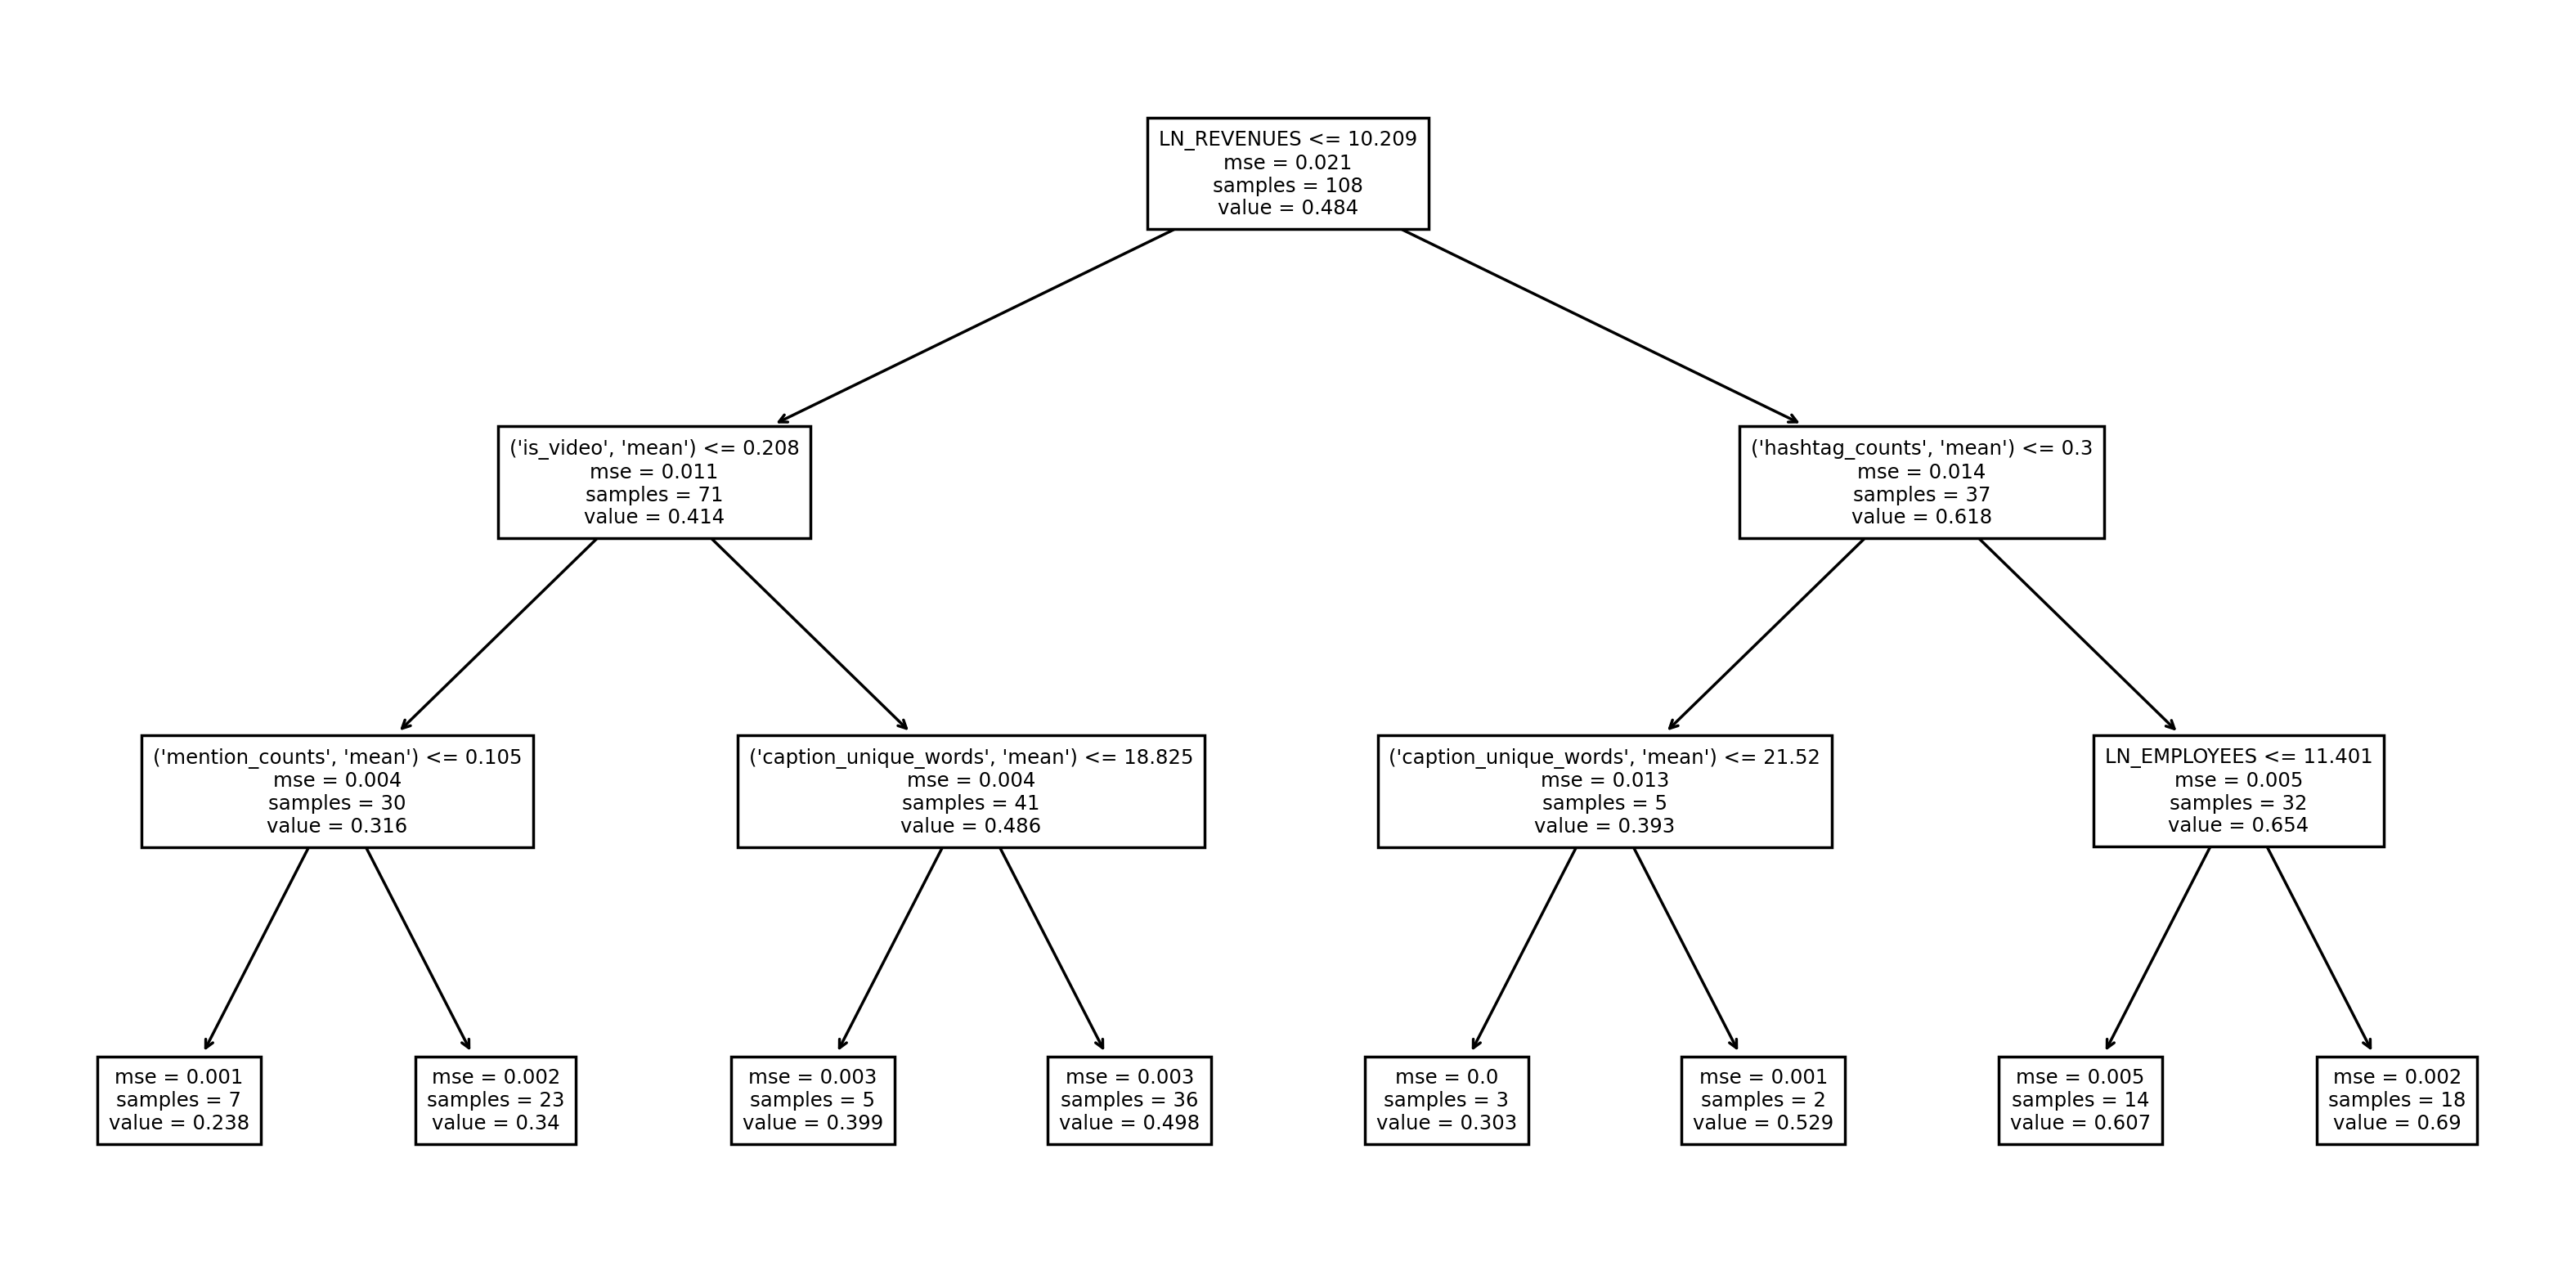

In [98]:
# Plot the tree
plt.figure(figsize=(16,8),dpi=250)
rules = tree.plot_tree(surrogate_model,feature_names=train_X.columns,fontsize=7)